# Analysis

In [2]:
import os, glob
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from Bio import SeqIO


plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['axes.spines.left'] = True
plt.rcParams['axes.spines.bottom'] = True
plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.facecolor'] = 'white'

## New analyses

Per ogni genoma la distribuzione delle lunghezze dei frammenti

In [ ]:
folders = ["../Data/BacDive/ncbi/Decompress/", "../Data/BacDive/Patric"]

fragment_lengths = []

for folder in folders:
    fna_files = glob.glob(os.path.join(folder, "*.fna"))
    
    for fna_file in fna_files:
        with open(fna_file, "r") as handle:
            for record in SeqIO.parse(handle, "fasta"):
                fragment_lengths.append(len(record.seq))

print(f"Numero frammenti: {len(fragment_lengths)}")


Numero frammenti: 30941


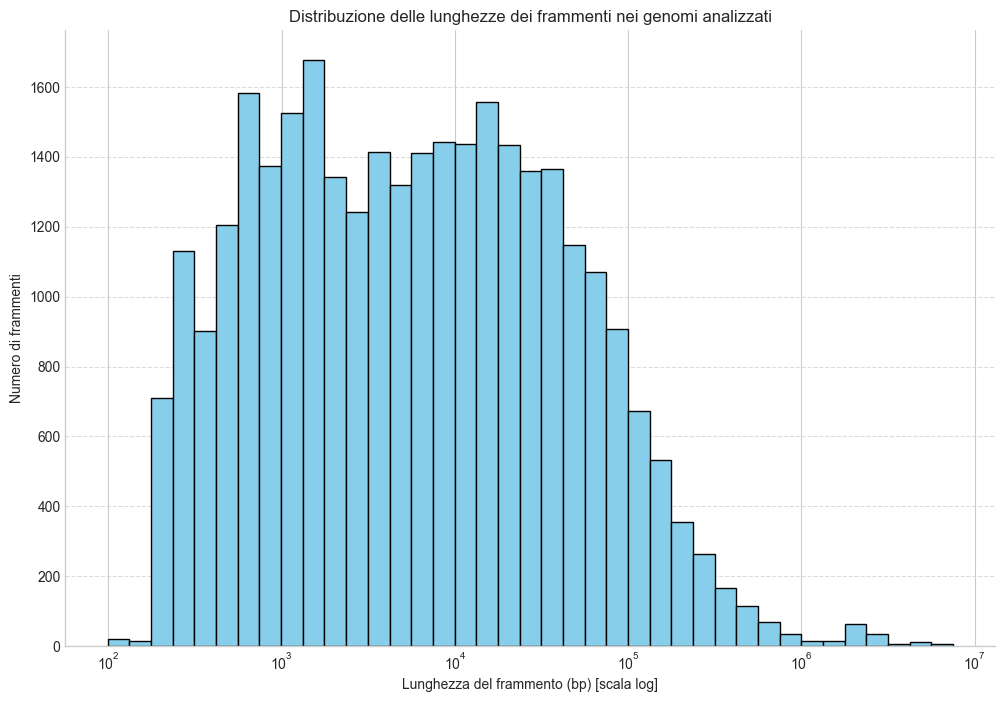

In [ ]:
bins = np.logspace(np.log10(min(fragment_lengths)), np.log10(max(fragment_lengths)), num=40)  # Bin logaritmici
hist, bin_edges = np.histogram(fragment_lengths, bins=bins)  # Conta i frammenti per ogni bin

plt.figure(figsize=(12, 8))
plt.bar(bin_edges[:-1], hist, width=np.diff(bin_edges), align="edge", color="skyblue", edgecolor="black")

plt.xscale("log")
plt.xlabel("Lunghezza del frammento (bp) [scala log]")
plt.ylabel("Numero di frammenti")
plt.title("Distribuzione delle lunghezze dei frammenti nei genomi analizzati")
plt.grid(axis="y", linestyle="--", alpha=0.7)

plt.show()

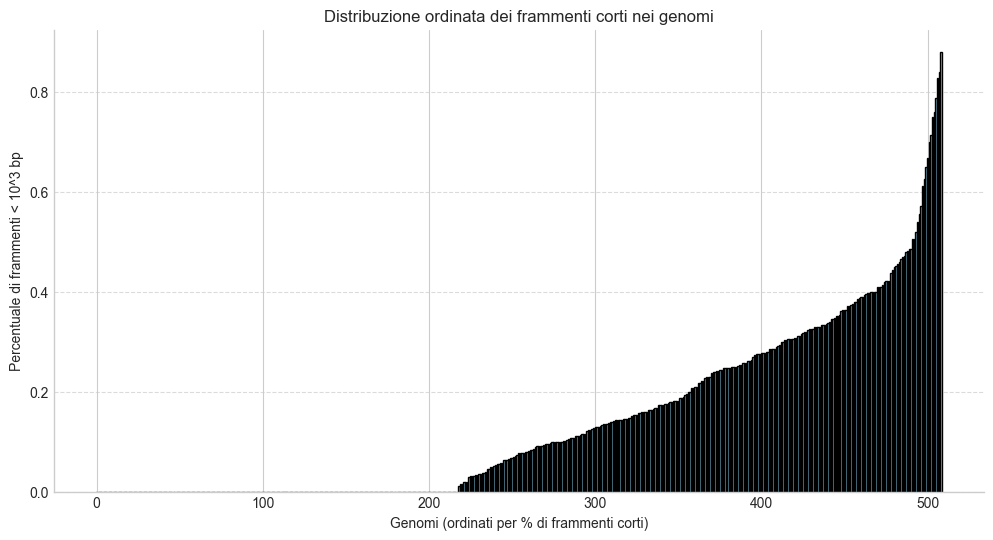

In [5]:
import os
import glob
import matplotlib.pyplot as plt
from Bio import SeqIO

folders = ["../Data/BacDive/ncbi/Decompress/", "../Data/BacDive/Patric"]

genome_data = []

for folder in folders:
    fna_files = glob.glob(os.path.join(folder, "*.fna"))
    
    for fna_file in fna_files:
        total_fragments = 0
        short_fragments = 0
        
        with open(fna_file, "r") as handle:
            for record in SeqIO.parse(handle, "fasta"):
                total_fragments += 1
                if len(record.seq) < 10**3:
                    short_fragments += 1
        
        if total_fragments > 0:
            ratio = short_fragments / total_fragments
            genome_data.append((os.path.basename(fna_file), ratio))

# Ordina per percentuale di frammenti corti
genome_data.sort(key=lambda x: x[1])

# Estrai i dati per il plot
genome_names, short_fragments_ratio = zip(*genome_data)

plt.figure(figsize=(12, 6))
plt.bar(range(len(genome_names)), short_fragments_ratio, color="skyblue", edgecolor="black")

plt.xlabel("Genomi (ordinati per % di frammenti corti)")
plt.ylabel("Percentuale di frammenti < 10^3 bp")
plt.title("Distribuzione ordinata dei frammenti corti nei genomi")

plt.grid(axis="y", linestyle="--", alpha=0.7)

plt.show()


In [6]:
import os
import glob
from Bio import SeqIO

folders = ["../Data/BacDive/ncbi/Decompress/", "../Data/BacDive/Patric"]

files_with_short_fragments = 0
total_files = 0

for folder in folders:
    fna_files = glob.glob(os.path.join(folder, "*.fna"))
    
    for fna_file in fna_files:
        total_files += 1
        has_short_fragment = False  # Flag per verificare se ci sono frammenti < 1000 bp

        with open(fna_file, "r") as handle:
            for record in SeqIO.parse(handle, "fasta"):
                if len(record.seq) < 1000:
                    has_short_fragment = True
                    break  # Se ne troviamo uno, non serve controllare il resto
        
        if has_short_fragment:
            files_with_short_fragments += 1

print(f"Numero totale di file analizzati: {total_files}")
print(f"Numero di file con almeno un frammento < 1000 bp: {files_with_short_fragments}")
print(f"Percentuale: {files_with_short_fragments / total_files * 100:.2f}%")


Numero totale di file analizzati: 509
Numero di file con almeno un frammento < 1000 bp: 291
Percentuale: 57.17%


In [3]:
import os
import glob
import pandas as pd
from Bio import SeqIO

# Cartelle con i file .fna
folders = ["../Data/BacDive/ncbi/Decompress/", "../Data/BacDive/Patric"]

# Lista per raccogliere i dati
data = []

# Soglia di lunghezza per i frammenti corti
threshold = 1000  

# Scansione delle cartelle
for folder in folders:
    fna_files = glob.glob(os.path.join(folder, "*.fna"))
    
    for fna_file in fna_files:
        genome_name = os.path.basename(fna_file)  # Nome file senza percorso
        short_fragments = 0  # Conta i frammenti < 1000 bp
        total_fragments = 0  # Conta i frammenti totali

        # Lettura del file FASTA
        with open(fna_file, "r") as handle:
            for record in SeqIO.parse(handle, "fasta"):
                total_fragments += 1
                if len(record.seq) < threshold:
                    short_fragments += 1

        # Salva i dati nel dataframe
        data.append({"Genoma": genome_name, "Frammenti Totali": total_fragments, "Frammenti Corti": short_fragments})

        # Stampa parziale per monitorare
        print(f"Numero di frammenti corti nel genoma {genome_name}: {short_fragments}")

df = pd.DataFrame(data)
df = df.sort_values(by="Frammenti Corti", ascending=False)

# Stampa risultati finali
print("\n📊 Riassunto Ordinato:")
print(df)

# Salva in CSV per analisi successive
df.to_csv("frammenti_corti_per_genoma.csv", index=False)


Numero di frammenti corti nel genoma GCA_001025135.1_ASM102513v1_genomic.fna: 0
Numero di frammenti corti nel genoma GCA_023657385.1_ASM2365738v1_genomic.fna: 13
Numero di frammenti corti nel genoma GCA_009764365.1_L._kimchii_genomic.fna: 0
Numero di frammenti corti nel genoma GCA_007989125.1_ASM798912v1_genomic.fna: 16
Numero di frammenti corti nel genoma GCA_002706425.1_ASM270642v1_genomic.fna: 0
Numero di frammenti corti nel genoma GCA_001543205.1_ASM154320v1_genomic.fna: 0
Numero di frammenti corti nel genoma GCA_000745125.1_ASM74512v1_genomic.fna: 0
Numero di frammenti corti nel genoma GCA_000241055.1_ASM24105v1_genomic.fna: 0
Numero di frammenti corti nel genoma GCA_000425865.1_ASM42586v1_genomic.fna: 0
Numero di frammenti corti nel genoma GCA_000498955.1_DSM-21115_genomic.fna: 153
Numero di frammenti corti nel genoma GCA_900476045.1_50279_D01_genomic.fna: 0
Numero di frammenti corti nel genoma GCA_000196555.1_ASM19655v1_genomic.fna: 0
Numero di frammenti corti nel genoma GCA_019

In [10]:
tmp = df[df['Frammenti Corti'] > 50].set_index('Genoma')
genomes = tmp.index

display(genomes)

Index(['GCA_000185065.2_ASM18506v1_genomic.fna', '1587.663.fna',
       'GCA_015698225.1_ASM1569822v1_genomic.fna', '1578.21.fna',
       'GCA_000498955.1_DSM-21115_genomic.fna', '1423769.4.fna',
       '1423789.3.fna', '518634.7.fna', '1423785.4.fna', '525366.3.fna',
       '525327.3.fna', '1133569.4.fna', '1218173.3.fna', '1423804.4.fna',
       '1423786.4.fna', '1046596.6.fna', '1423823.3.fna', '1423782.3.fna',
       '566552.17.fna', 'GCA_002217925.1_ASM221792v1_genomic.fna',
       '1131731.3.fna', '1423812.3.fna', '1293592.5.fna', '557436.17.fna',
       'GCA_007989185.1_ASM798918v1_genomic.fna', '585520.12.fna',
       '616990.3.fna', '1423829.3.fna',
       'GCA_001047135.1_ASM104713v1_genomic.fna', '888027.6.fna',
       '1122147.4.fna', '1590.625.fna', '525337.3.fna', '1423792.3.fna',
       'GCA_007991135.1_ASM799113v1_genomic.fna'],
      dtype='object', name='Genoma')

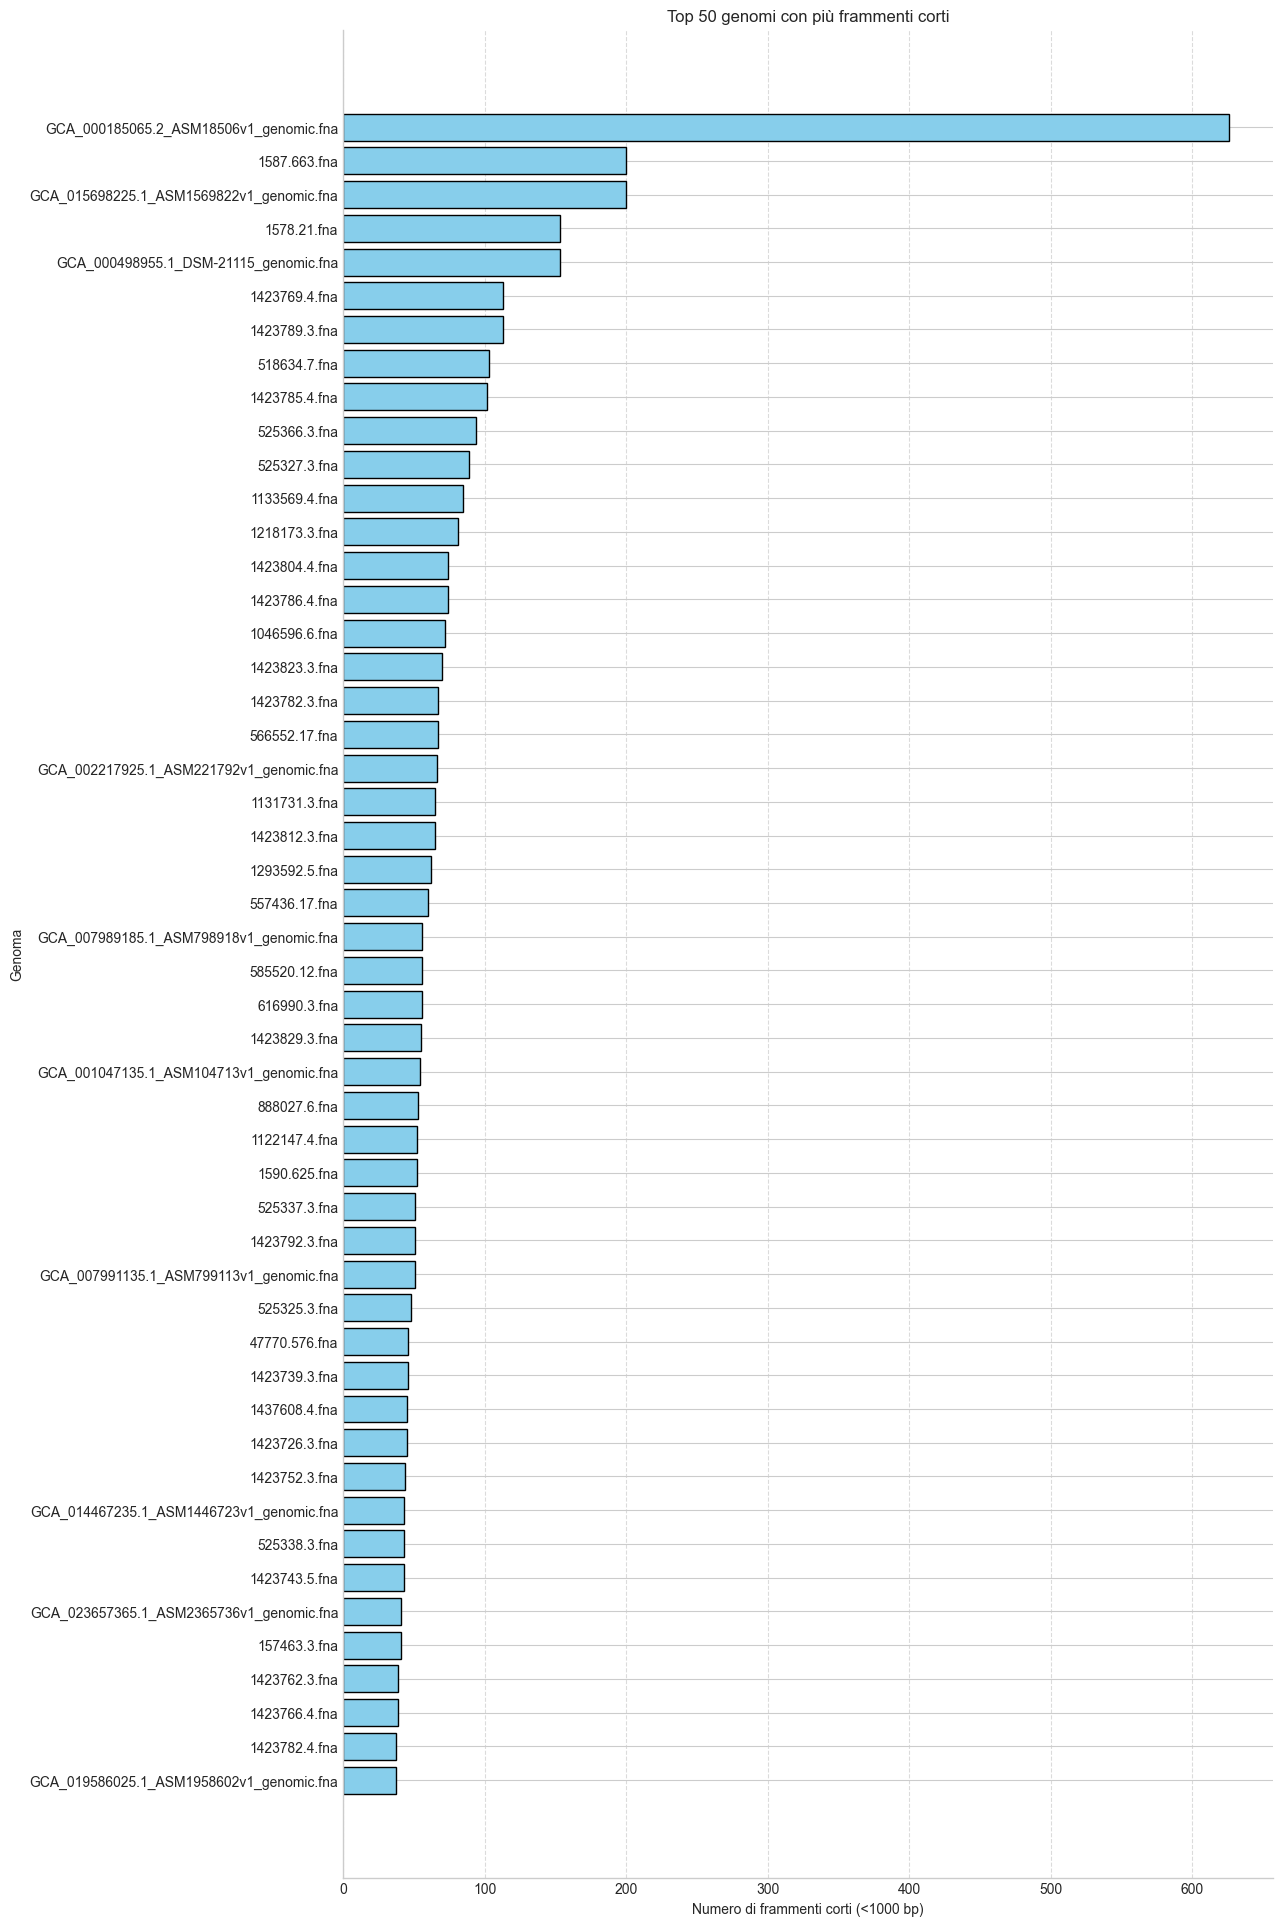

In [4]:
top_20 = df.head(50)

plt.figure(figsize=(12, 24))
plt.barh(top_20["Genoma"], top_20["Frammenti Corti"], color="skyblue", edgecolor="black")

plt.xlabel("Numero di frammenti corti (<1000 bp)")
plt.ylabel("Genoma")
plt.title("Top 50 genomi con più frammenti corti")
plt.gca().invert_yaxis()  # Inverte l'asse Y per avere il genoma con più frammenti in alto
plt.grid(axis="x", linestyle="--", alpha=0.7)

plt.show()

La distribuzione delle lunghezze dei geni

['../Data/BacDive/gff/ncbi/Decompress/GCA_001591685.1_ASM159168v1_genomic.gff', '../Data/BacDive/gff/ncbi/Decompress/GCA_900103655.1_IMG-taxon_2597490363_annotated_assembly_genomic.gff', '../Data/BacDive/gff/ncbi/Decompress/GCA_000615725.1_ASM61572v1_genomic.gff', '../Data/BacDive/gff/ncbi/Decompress/GCA_900187315.1_52087_C01_genomic.gff', '../Data/BacDive/gff/ncbi/Decompress/GCA_001311505.1_ASM131150v1_genomic.gff', '../Data/BacDive/gff/ncbi/Decompress/GCA_017654245.1_ASM1765424v1_genomic.gff', '../Data/BacDive/gff/ncbi/Decompress/GCA_014191315.1_ASM1419131v1_genomic.gff', '../Data/BacDive/gff/ncbi/Decompress/GCA_001436135.1_ASM143613v1_genomic.gff', '../Data/BacDive/gff/ncbi/Decompress/GCA_900637095.1_48450_G02_genomic.gff', '../Data/BacDive/gff/ncbi/Decompress/GCA_001025195.1_ASM102519v1_genomic.gff', '../Data/BacDive/gff/ncbi/Decompress/GCA_000615205.1_ASM61520v1_genomic.gff', '../Data/BacDive/gff/ncbi/Decompress/GCA_002777965.1_ASM277796v1_genomic.gff', '../Data/BacDive/gff/ncbi/D

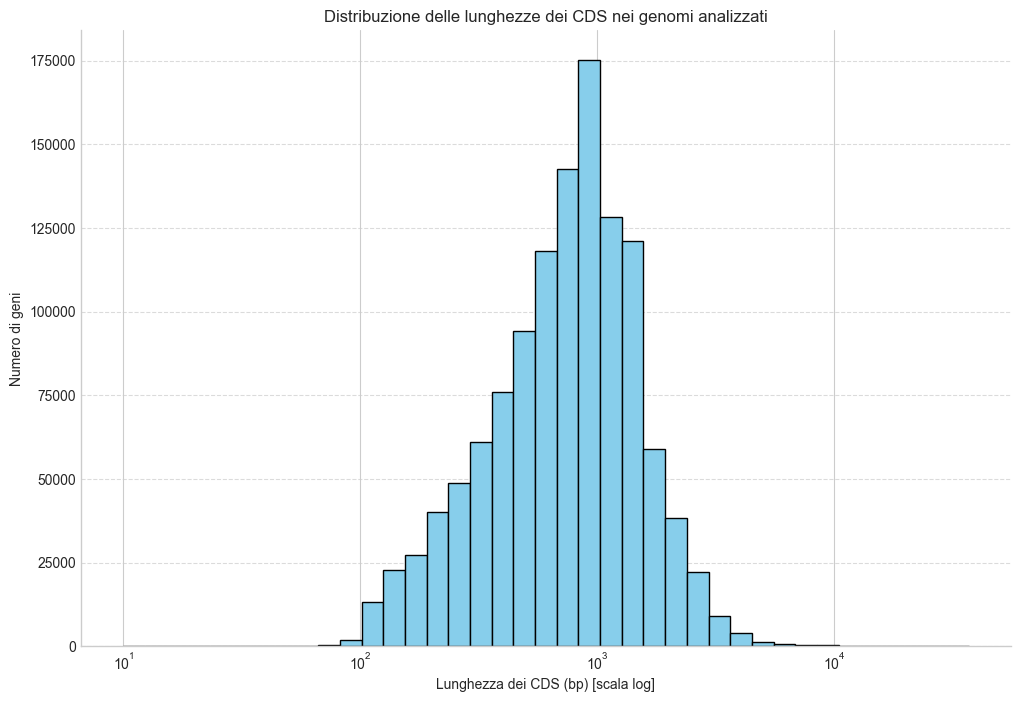

In [33]:
dir1 = "../Data/BacDive/gff/ncbi/Decompress/"
dir2 = "../Data/BacDive/gff/Patric/"
# dir1 = "../Data/BacDive/gff/test/"

gff_files = glob.glob(os.path.join(dir1, "*.gff")) + glob.glob(os.path.join(dir2, "*.gff"))

cds_lengths = []

print(gff_files)

for gff_file in gff_files:
    with open(gff_file, "r") as f:
        for line in f:
            if line.startswith("#"):  # Ignora commenti
                continue
            fields = line.strip().split("\t")
            if len(fields) < 5:
                continue
            feature_type = fields[2]
            if feature_type == "CDS":  # Considera solo i CDS
                start, end = int(fields[3]), int(fields[4])
                length = abs(end - start) + 1  # Lunghezza del CDS
                cds_lengths.append(length)

with open("cds_lengths.csv", "w") as out_file:
    out_file.write("CDS_Length\n")
    for length in cds_lengths:
        out_file.write(f"{length}\n")


bins = np.logspace(np.log10(10), np.log10(max(cds_lengths)), num=40)
hist, bin_edges = np.histogram(cds_lengths, bins=bins)

plt.figure(figsize=(12, 8))
plt.bar(bin_edges[:-1], hist, width=np.diff(bin_edges), align="edge", color="skyblue", edgecolor="black")

plt.xscale("log")
plt.xlabel("Lunghezza dei CDS (bp) [scala log]")
plt.ylabel("Numero di geni")
plt.title("Distribuzione delle lunghezze dei CDS nei genomi analizzati")
plt.grid(axis="y", linestyle="--", alpha=0.7)

plt.show()


## Number of sequences in each strain

Calculate and plot the number of sequences required to extract the DNA for each strain.

In [3]:
def plot_info_sequences(dataframe):
    
    plt.figure(figsize=(45,12))
    plt.title('Number of sequences for each strain')
    
    palette = sns.color_palette('colorblind', n_colors=len(dataframe['Database'].unique()))
    category_color_map = {category: color for category, color in zip(dataframe['Database'].unique(), palette)}
    
    legend_entries = {}
    
    for index, row in dataframe.iterrows():
        category = row['Database']
        
        if category not in legend_entries:
            legend_entries[category] = plt.bar(row['Strain'], row['Number of sequences'], color=category_color_map[category], label=category)
        else:
            plt.bar(row['Strain'], row['Number of sequences'], color=category_color_map[category])
    
    plt.xlabel('Strain')
    plt.ylabel('Number of sequences')
    plt.xticks(rotation=45, ha='right')
    
    plt.legend()
    plt.tight_layout()
    
    # os.makedirs(f"./Result/Images/", exist_ok=True)
    # output_path = os.path.join(f"./Result/Images/{file_name}.png")
    # plt.savefig(output_path)
    
    plt.show()
    plt.close()

,Number of sequences,Database
Strain,,
GCA_007992315,41,ncbi
GCA_002259745,28,ncbi
GCA_000771085,0,ncbi
GCA_000010425,1,ncbi
GCA_002706745,1,ncbi
...,...,...
862514.3,1,Patric
1220560.3,101,Patric
203120.23,1,Patric


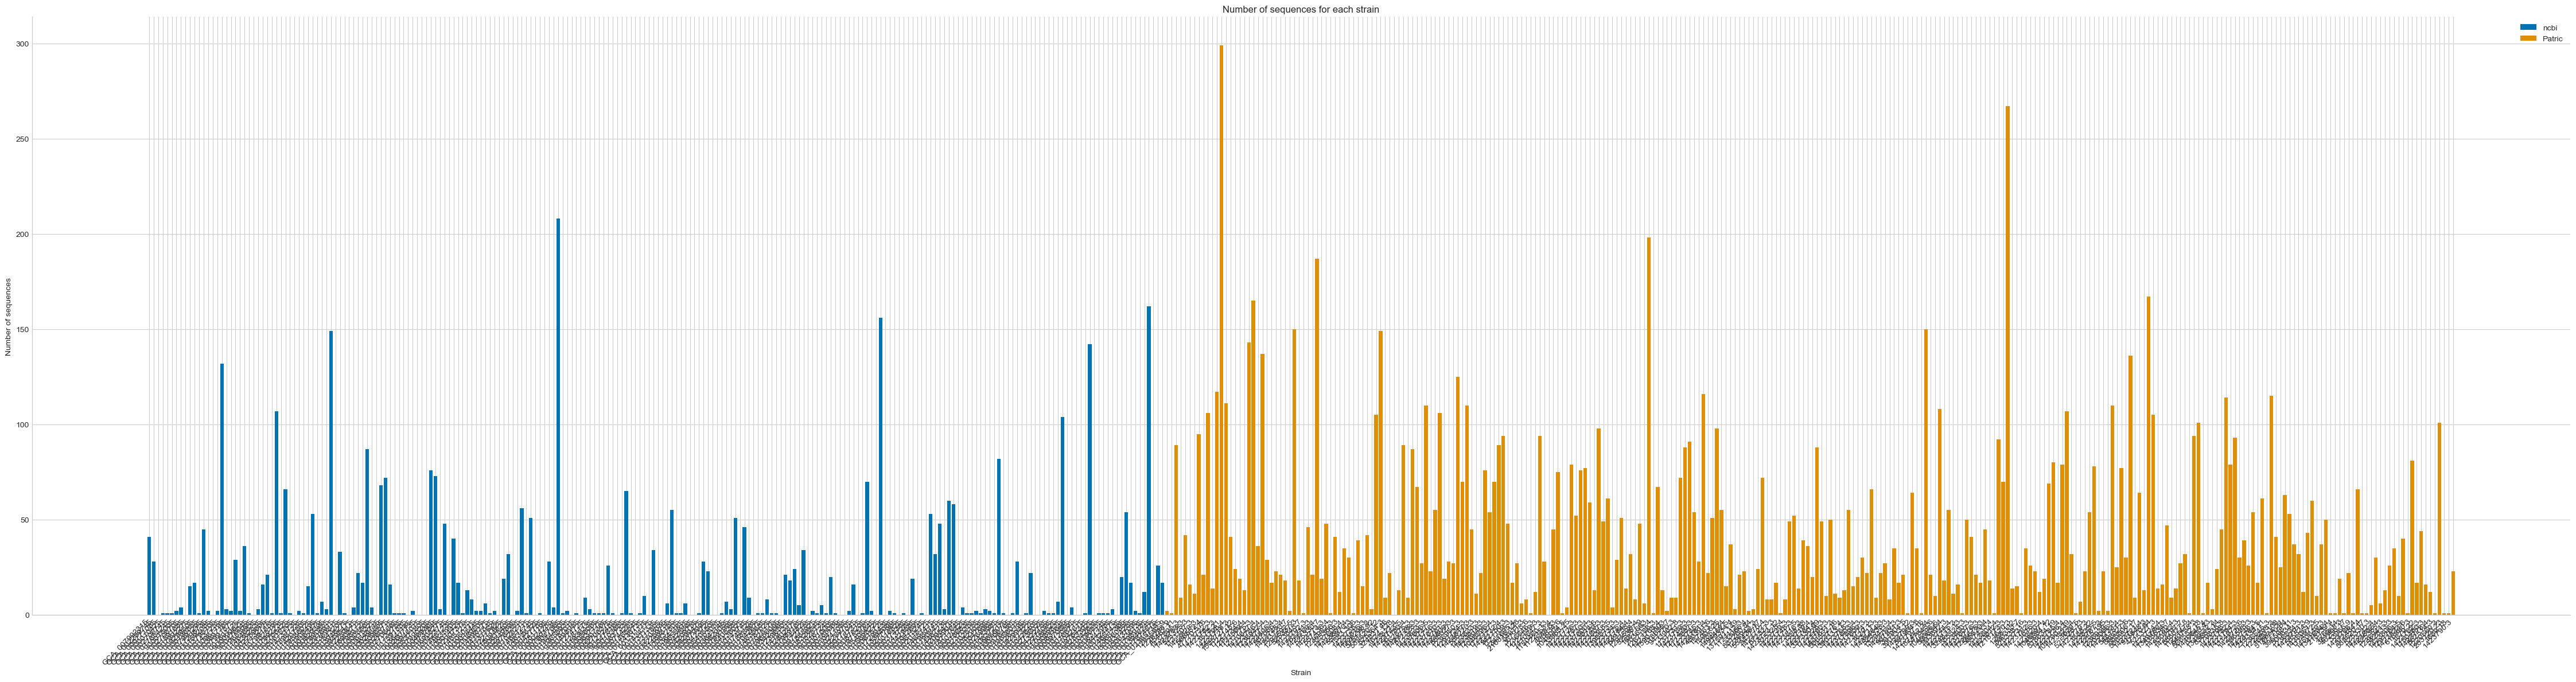

In [ ]:
path = '../Result/Coverages/Gene_Importances/AMYgdalin/' # There is no differences between folders for this analysis.
output = pd.DataFrame(columns=['Strain', 'Number of sequences', 'Database'])

files = os.listdir(path)
xlsx_files = [file for file in files if file.endswith('.xlsx')]


for file in xlsx_files:
    if not file.startswith('~$'): # Avoid reading xlsx files that are temporarily open.
        file_path = os.path.join(path, file)

        coverage = pd.read_excel(file_path)

        strain = file[:-5]
        num_sequences = len(coverage['Sequence'].unique())
        database = 'ncbi' if file.startswith('GCA') else 'Patric'

        row = pd.DataFrame({'Strain': [strain], 'Number of sequences': [num_sequences], 'Database': [database]})
        
        output = pd.concat([output, row], ignore_index=True)            
        
output = output.sort_values(by=['Database'], ascending=False)

display(output.set_index('Strain'))
plot_info_sequences(output)

with pd.ExcelWriter('./Result/strain_sequences.xlsx') as writer:
    output.to_excel(writer, index=False)

## Coverage of DNA

Calculate and plot the coverage of the DNA captured by AFLP.

In [5]:
def caluclate_aflp_coverage(strain, aflp_min, aflp_max):
    coverages = dict()
    
    print(filemap[strain], end=', ')
    
    with open('Data/BacDive/AFLP_perl/'+filemap[strain], 'r') as iff:
        for line in iff:
            
            cc = line.strip().split('\t')
            
            if len(cc) == 9: # prende in considerazioni righe fatte da 9 campi, come: 1	KE386622	1745633	GAATTC	534628	TTAA	534632	10	TTAAGAATTC

                flen = int(cc[7]) # fragment_length
                
                if (flen>=aflp_min) and (flen<=aflp_max):
                    seq = cc[1]

                    if seq not in coverages:
                        coverages[seq] = [False for i in range(int(cc[2]))]

                    istart = int(cc[4])
                    imax = int(cc[6])
                    if istart > imax:
                        print(cc)
                    for i in range(istart, istart+flen):
                        coverages[seq][i] = True
    covered = 0
    total = 0
    for k,v in coverages.items():
        total += len(v)
        covered += sum(v)
        # print('#',k, len(v), sum(v))
    return covered, total

In [ ]:
filemap = dict()
aflp_coverages = list()

files = [f for f in os.listdir('Data/BacDive/AFLP_perl') if os.path.isfile('Data/BacDive/AFLP_perl/'+f)]
df_X = pd.read_excel('Data/X.xlsx')
strains = list(df_X['strain'])


for f in files:
    if 'GCA' in f:
        filemap[f[:f.index('.')]] = f
    else:
        filemap[f.replace('.wri','')] = f
        

for st in strains:
    covered, total = caluclate_aflp_coverage(st, 50, 500)
    
    if total > 0 :
        aflp_coverages.append(covered/total)
    else:
        aflp_coverages.append(0)
        
        

# Plot the coverage        
plt.figure(figsize=(7, 7))

plt.scatter( [i for i in range(len(aflp_coverages))], sorted(aflp_coverages), marker='D', s=15)

plt.title('AFLP coverage', fontsize=15, pad=20)
plt.xlabel('Sample', fontsize=13)
plt.ylabel('Coverage', fontsize=13)

plt.xticks(fontsize=11)
plt.yticks(fontsize=11)

plt.savefig('Result/Images/coverage.png')
plt.show()